In [2]:
import numpy as np
import matplotlib.pyplot as plt

def solve_fd_robust(Q, Pd, N=101, H_guess=None):
    '''
    Solves for channel shape H and pressure P.
    '''
    dx = 1.0 / (N - 1)
    x = np.linspace(0, 1, N)

    # Use provided guess or default to flat tube
    if H_guess is None:
        H = np.ones(N)
    else:
        H = H_guess.copy()

    damping = 0.5

    for iter_idx in range(50): # Newton iterations
        J = np.zeros((N, N))
        F = np.zeros(N)

        # BC: Upstream H(0) = 1
        F[0] = H[0] - 1.0
        J[0, 0] = 1.0

        # BC: Downstream Pressure H''(L) = -Pd
        coeff_pres = np.array([-1, 4, -5, 2]) / dx**2
        idxs_p = [N-4, N-3, N-2, N-1]
        H_xx = np.dot(coeff_pres, H[idxs_p])
        F[1] = H_xx + Pd
        for k, node in enumerate(idxs_p):
            J[1, node] = coeff_pres[k]

        # Interior ODE (Central)
        coeff_cen = np.array([-1, 2, 0, -2, 1]) / (2 * dx**3)
        for i in range(2, N-2):
            idxs = [i-2, i-1, i, i+1, i+2]
            H_loc = H[idxs]
            H_xxx = np.dot(coeff_cen, H_loc)

            F[i] = H_xxx * (H[i]**3) - Q

            for k, node in enumerate(idxs):
                term = coeff_cen[k] * (H[i]**3)
                if node == i: term += H_xxx * 3 * (H[i]**2)
                J[i, node] = term

        # Boundary ODE (Backward)
        i = N-2
        coeff_back = np.array([1, -6, 12, -10, 3]) / (2 * dx**3)
        idxs = [i-3, i-2, i-1, i, i+1]
        H_loc = H[idxs]
        H_xxx = np.dot(coeff_back, H_loc)
        F[i] = H_xxx * (H[i]**3) - Q
        for k, node in enumerate(idxs):
            term = coeff_back[k] * (H[i]**3)
            if node == i: term += H_xxx * 3 * (H[i]**2)
            J[i, node] = term

        # BC: Downstream H(L) = 1
        F[N-1] = H[N-1] - 1.0
        J[N-1, N-1] = 1.0

        # Solve
        if np.linalg.norm(F, np.inf) < 1e-6:
            break

        try:
            delta = np.linalg.solve(J, -F)
            H_new = H + damping * delta
            # Clamps
            H_new[H_new < 0.01] = 0.01
            H_new[H_new > 10.0] = 10.0
            H = H_new
        except np.linalg.LinAlgError:
            break # Return best effort

    # Compute Pressure
    P = np.zeros_like(x)
    for i in range(1, N-1):
        P[i] = -(H[i-1] - 2*H[i] + H[i+1]) / (dx**2)
    P[0] = 2*P[1] - P[2]
    P[-1] = Pd

    return x, H, P

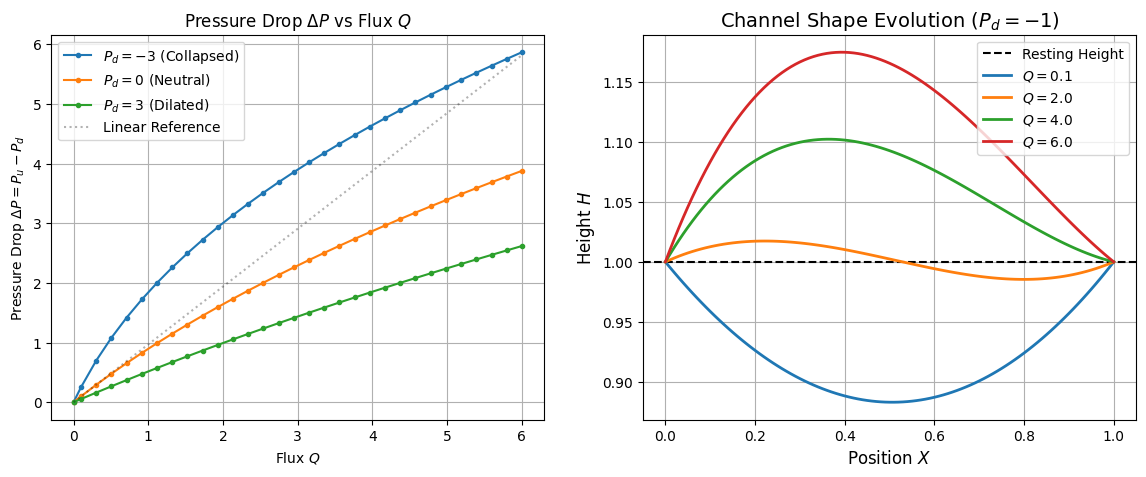

In [18]:
Pd_values = [-3, 0, 3]  # Negative, Zero, Positive
Pd_fixed = -1
Q_values = np.linspace(0.1, 6.0, 30) # Range of flux
Q_examples = [0.1, 2.0, 4.0, 6.0]

results = {}

for Pd in Pd_values:
    DeltaP_list = []

    # Initial guess for the chain, start from flat
    current_H = np.ones(101)

    # We add (0,0) manually because at Q=0, DeltaP is exactly 0
    Q_plot = [0] + list(Q_values)

    for Q in Q_values:
        # Use previous solution as continuation guess for next step
        _, H_res, P_res = solve_fd_robust(Q, Pd, H_guess=current_H)

        current_H = H_res # Update guess

        # P_upstream = P(0), P_downstream = Pd
        # Delta P = P_u - P_d
        P_upstream = P_res[0]
        DeltaP = P_upstream - Pd
        DeltaP_list.append(DeltaP)

    results[Pd] = [0] + DeltaP_list # Prepend 0 for Q=0

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for Pd in Pd_values:
    label_str = f'$P_d = {Pd}$ ({"Dilated" if Pd>0 else "Collapsed" if Pd<0 else "Neutral"})'
    ax[0].plot(Q_plot, results[Pd], '.-', label=label_str)
ax[0].plot([0, 6], [0, results[0][-1]*1.5], 'k:', alpha=0.3, label='Linear Reference')
ax[0].set_title(r'Pressure Drop $\Delta P$ vs Flux $Q$')
ax[0].set_xlabel('Flux $Q$')
ax[0].set_ylabel(r'Pressure Drop $\Delta P = P_u - P_d$')
ax[0].legend()
ax[0].grid(True)

ax[1].axhline(1.0, color='k', linestyle='--', label='Resting Height')
for Q in Q_examples:
    x_res, H_res, _ = solve_fd_robust(Q, Pd_fixed)
    ax[1].plot(x_res, H_res, linewidth=2, label=f'$Q = {Q}$')
ax[1].set_title(f'Channel Shape Evolution ($P_d = {Pd_fixed}$)')
ax[1].set_xlabel('Position $X$', fontsize=12)
ax[1].set_ylabel('Height $H$', fontsize=12)
ax[1].legend()
ax[1].grid(True)

plt.show()

The graphs of $\Delta P$ vs. $Q$ are concave. The slope $\frac{d(\Delta P)}{dQ}$ is initially steep but decreases as $Q$ increases. In standard Poiseuille flow through a rigid pipe, the relationship is linear $\Delta P = RQ$, where resistance $R$ is constant. However, in this collapsible tube, the walls deform based on the internal pressure.

To drive a higher flux $Q$, the upstream pressure $P_u$ must increase. This increase in internal pressure pushes against the membrane, since $P \approx -H_{xx}$, causing the channel height $H$ to increase. The resistance of a channel scales as $R \propto \frac{1}{H^3}$ which decreases when the channel height $H$ increases since $Q$ increases. Since $\Delta P \approx Q \cdot R(Q)$ and $R(Q)$ is getting smaller, the pressure drop $\Delta P$ need not rise as fast as $Q$. The tube becomes more efficient at transporting fluid at higher flow rates because it widens to accommodate the flow. This explains why the slope of the graph falls.

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import brentq

def solve_fd_eigenvalue(Pu, Pd, N=51, guess_state=None):
    '''
    Solves for [H, Q] given fixed Pu and Pd.
    Accepts a guess to enable continuation.
    '''
    dx = 1.0 / (N - 1)

    # State Vector: [H_0, ..., H_N-1, Q]
    if guess_state is None:
        # Initial cold start: flat tube, Q = 0
        state = np.ones(N + 1)
        state[-1] = 0.5 # Small initial flux guess
    else:
        state = guess_state.copy()

    damping = 0.8

    for iter_idx in range(50): # Newton loop
        H = state[:-1]
        Q = state[-1]

        # Dense matrix
        J = np.zeros((N+1, N+1))
        F = np.zeros(N+1)

        # Upstream BCs H(0) = 1
        F[0] = H[0] - 1.0
        J[0, 0] = 1.0

        # H''(0) = -Pu Forward (H_0 - 2H_1 + H_2)/dx^2 + Pu = 0
        F[1] = (H[0] - 2*H[1] + H[2])/(dx**2) + Pu
        J[1, 0] = 1/dx**2; J[1, 1] = -2/dx**2; J[1, 2] = 1/dx**2

        # Downstream BCs H(L) = 1
        F[N-1] = H[N-1] - 1.0
        J[N-1, N-1] = 1.0

        # 4. H''(L) = -Pd Backward (H_N-3 - 2H_N-2 + H_N-1)/dx^2 + Pd = 0
        F[N] = (H[N-3] - 2*H[N-2] + H[N-1])/(dx**2) + Pd
        J[N, N-3] = 1/dx**2; J[N, N-2] = -2/dx**2; J[N, N-1] = 1/dx**2

        # Interior ODEs
        coeff_cen = np.array([-1, 2, 0, -2, 1]) / (2 * dx**3)
        for i in range(2, N-2):
            idxs = [i-2, i-1, i, i+1, i+2]
            H_loc = H[idxs]
            H_xxx = np.dot(coeff_cen, H_loc)

            F[i] = H_xxx * (H[i]**3) - Q

            # Jacobian with respect to H
            for k, node in enumerate(idxs):
                term = coeff_cen[k] * (H[i]**3)
                if node == i: term += H_xxx * 3 * (H[i]**2)
                J[i, node] = term

            # Jacobian with respect to Q
            J[i, N] = -1.0

        # Boundary ODE
        i = N-2
        coeff_back = np.array([1, -6, 12, -10, 3]) / (2 * dx**3)
        idxs = [i-3, i-2, i-1, i, i+1]
        H_loc = H[idxs]
        H_xxx = np.dot(coeff_back, H_loc)
        F[i] = H_xxx * (H[i]**3) - Q
        for k, node in enumerate(idxs):
            term = coeff_back[k] * (H[i]**3)
            if node == i: term += H_xxx * 3 * (H[i]**2)
            J[i, node] = term
        J[i, N] = -1.0

        # Solve
        if np.linalg.norm(F, np.inf) < 1e-5:
            return True, state

        try:
            delta = np.linalg.solve(J, -F)
            state = state + damping * delta
            # Clamps
            state[:-1][state[:-1] < 0.001] = 0.001
            if state[-1] < 0: state[-1] = 0.0

        except np.linalg.LinAlgError:
            return False, state

    return False, state

def solve_shooting_check(Q, Pu):
    '''Finds all valid DeltaPs for a fixed Q and Pu'''
    def tube_ode(t, y):
        H, Hp, Hpp = y
        denom = H**3 if H > 1e-4 else 1e-4
        return [Hp, Hpp, Q/denom]

    def residual(alpha):
        try:
            sol = solve_ivp(tube_ode, [0, 1], [1.0, alpha, -Pu], method='Radau', rtol=1e-4)
            return sol.y[0][-1] - 1.0
        except: return 100.0

    alphas = np.linspace(-40, 40, 100)
    vals = [residual(a) for a in alphas]
    found_dps = []

    for i in range(len(vals)-1):
        if vals[i] * vals[i+1] < 0:
            try:
                root = brentq(residual, alphas[i], alphas[i+1])
                sol = solve_ivp(tube_ode, [0, 1], [1.0, root, -Pu], method='Radau')
                Pd_found = -sol.y[2][-1]
                found_dps.append(Pu - Pd_found)
            except: pass
    return found_dps

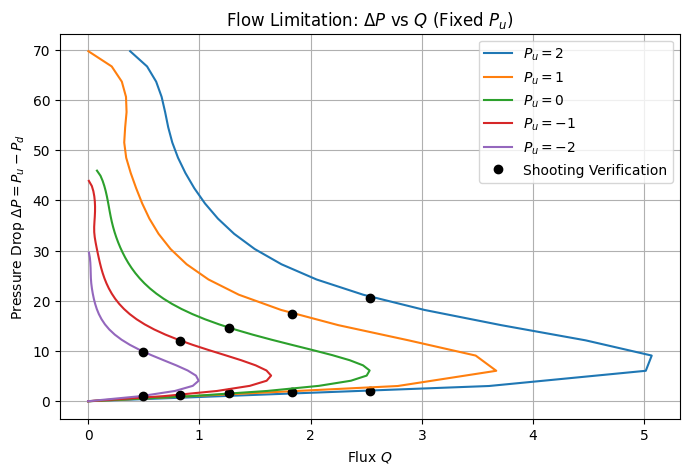

In [10]:
Pu_values = [2, 1, 0, -1, -2]
plt.figure(figsize=(8, 5))

for i, Pu in enumerate(Pu_values):

    q_curve = []
    dp_curve = []

    # Continuation: Start with Q = 0 at Pd = Pu
    current_state = np.ones(52)
    current_state[-1] = 0.0

    # We define a scan of DeltaP (Pressure drops)
    if Pu > 0:
        delta_p_scan = np.linspace(0, 300, 100)
    else:
        delta_p_scan = np.linspace(0, 50, 50)

    for dp in delta_p_scan:
        Pd_target = Pu - dp

        success, new_state = solve_fd_eigenvalue(Pu, Pd_target, guess_state=current_state)

        if success:
            current_state = new_state # Update guess
            q_val = new_state[-1]
            q_curve.append(q_val)
            dp_curve.append(dp)
        else:
            break

    plt.plot(q_curve, dp_curve, '-', label=f'$P_u={Pu}$')
    if len(q_curve) > 5:
        verif_Q = max(q_curve) * 0.5
        if verif_Q > 0.1:
            check_dps = solve_shooting_check(verif_Q, Pu)
            for dp_check in check_dps:
                plt.plot(verif_Q, dp_check, 'ko')

plt.plot([], [], 'ko', label='Shooting Verification')
plt.title(r'Flow Limitation: $\Delta P$ vs $Q$ (Fixed $P_u$)')
plt.xlabel('Flux $Q$')
plt.ylabel(r'Pressure Drop $\Delta P = P_u - P_d$')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

We observe flow limitation, a phenomenon where increasing the driving pressure drop $\Delta P$ eventually causes the flow rate $Q$ to saturate or even decrease. This creates a turning point in the $Q$ vs $\Delta P$ curve manifesting as nose-shaped curves.

As $Q$ increases, $\Delta P$ increases which is the normal resistive behavior. The curve reaches a maximum $Q$ known as the flow limitation point. As $\Delta P$ continues to increase (moving up the Y-axis), $Q$ actually decreases.

This demonstrates non-uniqueness. A vertical line at a specific $Q < Q_{\max}$ intersects the curve twice.

*   The lower intersection corresponds to a mildly deformed channel.
*   The higher intersection corresponds to a highly collapsed channel.

High collapse implies high resistance, so a large $\Delta P$ is needed to drive the same flux $Q$.

The fall in flux as pressure drop increases is caused by the Bernoulli effect and compliant walls. To increase $\Delta P$, we lower the downstream pressure $P_d$. Lowering $P_d$ causes the channel walls to move inward, reducing the cross-sectional area $A$ near the outlet. Resistance scales as $R \sim 1/A^3$ so a small decrease in $A$ causes a large increase in resistance. Eventually, the increase in resistance outweighs the increase in driving pressure. This causes flow limitation.

For large $\Delta P = 150$, we see an 'S-bend' in the plots. As $\Delta P$ gets very high, the point of collapse moves upstream. The interaction between the moving collapse point and the viscous pressure loss causes the resistance to fluctuate, creating this bend where the slope momentarily turns positive before going back negative.